# Gas Cooled Reactor 



In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et

In [2]:
# fuel materials from er362_omc > examples > microreactor > haleu_gcr > pf0p3

# HALEU in triso particles in graphite matrix
# packing factor = 0.3
fuel = openmc.Material(name="fuel_compact")
fuel.set_density('atom/b-cm',8.3732e-2) # To Do: implement a better method for adjusting triso fuel parameters
fuel.add_nuclide('U235',2.11720e-4)
fuel.add_nuclide('U238',8.5221e-4)
fuel.add_element('C',7.7953e-2)
fuel.add_element('O',2.1279e-3)
fuel.add_element('S',2.5875e-3)
fuel.add_s_alpha_beta('c_Graphite')
fuel.depletable = True


coolant = openmc.Material(name='He')
coolant.set_density('g/cm3',1.86e-3) # at 3MPa, 500 C (need to fix)
coolant.add_element('He',1.0)
 # no s_alpha_beta for Helium??
    
    
mod = openmc.Material(name='Graphite')
mod.set_density('g/cm3',1.7)
mod.add_element('C',1)
mod.add_s_alpha_beta('c_Graphite')

materials = openmc.Materials([fuel,coolant,mod]);

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.6; #cm, radius of fuel compact
r_channel = 0.8;#cm, radius of fuel channel 

P_D = 1.58

pitch = P_D*(2*r_channel);

fuel_temp = 1200; # K, representative fuel temperature (?)
mod_temp = 800; # K, representative moderator temperature (?)

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# channel cylinder
channel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_core/2+1.],
                                            h_core-2.,r_channel);
# avoid coincident boundaries with the core cell

# core cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


channel_cell = openmc.Cell();
channel_cell.region = +fuel_cyl & -channel_cyl;
channel_cell.fill = coolant;

mod_cell = openmc.Cell();
mod_cell.region = +channel_cyl & -core_cell;
mod_cell.fill = mod
mod_cell.temperature = mod_temp;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,channel_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();

colors = {}
colors[fuel]='yellow'
colors[mod]='grey'
colors[coolant]='pink'

In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

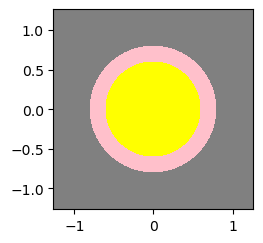

In [5]:
root_univ.plot(width=(pitch,pitch),pixels=[200,200],color_by='material',colors=colors);

In [6]:
plot = openmc.Plot()
plot.filename = 'HALEU_GCR'
plot.width = (pitch, pitch)
plot.pixels = (400, 400)
plot.color_by = 'material'
plot.colors = {fuel: 'yellow', coolant: 'blue', mod: 'grey'}

plots = openmc.Plots([plot])
plots.export_to_xml()
openmc.plot_geometry()
!convert model3.ppm model3.png

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

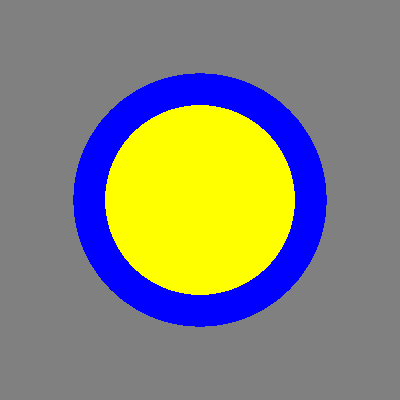

In [7]:
from IPython.display import Image
Image("HALEU_GCR.png")

In [8]:
model = openmc.model.Model(geometry,materials,settings)
operator = openmc.deplete.CoupledOperator(model,"chain_endfb71_pwr.xml");

# typical PWR power density
full_pd = 20.0; # W/gHM, estimate
power_density = [full_pd,full_pd,full_pd,full_pd,full_pd,
                full_pd,full_pd,full_pd,full_pd,full_pd,
                0,0,0,0,0]; # power density W/gHM 
# power 0 after 4.5 years with cooldown steps of a day, week, month to 2 years
days = 24*3600;
time_steps = [0.5*days,0.5*days,1*days,5*days,
              23*days,150*days,365*days,365*days,
              365*days,365*days,
              1*days,6*days,23*days,335*days,365*days];
cecm = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density);

repeat_depletion = False


if(repeat_depletion):
    cecm.integrate()

In [9]:
# get depletion results to manipulate
r = openmc.deplete.Results('depletion_results.h5')
burned_mats = r.export_to_materials(burnup_index=15)
burned_mats.export_to_xml('BurnedMaterials15.xml')

In [10]:
print(burned_mats)

[Material
	ID             =	1
	Name           =	fuel_compact
	Temperature    =	None
	Density        =	0.083732 [sum]
	S(a,b) Tables  
	S(a,b)         =	('c_Graphite', 1.0)
	Nuclides       
	C0             =	0.07795269277709098 [ao]
	Ac225          =	2.4792322562953713e-22 [ao]
	Ac226          =	6.6939155769095594e-40 [ao]
	Ac227          =	6.47612710015809e-17 [ao]
	Ag107          =	6.768694463578832e-14 [ao]
	Ag109          =	5.990851660708184e-08 [ao]
	Ag110_m1       =	1.1484594455773674e-11 [ao]
	Ag111          =	5.157687789392671e-40 [ao]
	Al27           =	1.4519959418443092e-17 [ao]
	Am240          =	8.361858343500937e-32 [ao]
	Am241          =	7.435729549642991e-08 [ao]
	Am242          =	3.0608234707385912e-15 [ao]
	Am242_m1       =	2.372404618392691e-10 [ao]
	Am243          =	9.943783346623266e-10 [ao]
	Am244          =	6.241067879394354e-26 [ao]
	Ar36           =	3.7552991124415373e-16 [ao]
	Ar38           =	1.794060092717742e-15 [ao]
	Ar40           =	1.001005875512118e-21 [ao

In [11]:
mat_tree = et.parse('BurnedMaterials15.xml')
root = mat_tree.getroot()
i=0
for child in root:
    if child.attrib['name']=='fuel_compact':
        uo2_elem = root[i]
    i+=1

In [12]:
# create Material object from element in burned Materials object
uo2_elem.set('id',23)
print(uo2_elem.items())
type(uo2_elem)
burned_uo2 = openmc.Material.from_xml_element(uo2_elem)
burned_uo2_mass = burned_uo2.get_mass()

#burned_uo2 = openmc.Material(name='burned_uo2')
#Burned_uo2 = burned_uo2.from_xml_element(uo2_elem)
print(burned_uo2)
print(burned_uo2_mass)

[('depletable', 'true'), ('id', 23), ('name', 'fuel_compact'), ('volume', '226.1946710584651')]
Material
	ID             =	23
	Name           =	fuel_compact
	Temperature    =	None
	Density        =	None [sum]
	S(a,b) Tables  
	S(a,b)         =	('c_Graphite', 1.0)
	Nuclides       
	C0             =	0.07795269277709098 [ao]
	Ac225          =	2.4792322562953713e-22 [ao]
	Ac226          =	6.6939155769095594e-40 [ao]
	Ac227          =	6.47612710015809e-17 [ao]
	Ag107          =	6.768694463578832e-14 [ao]
	Ag109          =	5.990851660708184e-08 [ao]
	Ag110_m1       =	1.1484594455773674e-11 [ao]
	Ag111          =	5.157687789392671e-40 [ao]
	Al27           =	1.4519959418443092e-17 [ao]
	Am240          =	8.361858343500937e-32 [ao]
	Am241          =	7.435729549642991e-08 [ao]
	Am242          =	3.0608234707385912e-15 [ao]
	Am242_m1       =	2.372404618392691e-10 [ao]
	Am243          =	9.943783346623266e-10 [ao]
	Am244          =	6.241067879394354e-26 [ao]
	Ar36           =	3.7552991124415373e-16 [

In [13]:
listnuc = burned_uo2.get_nuclides() # list of nuclides present in burned fuel

In [14]:
# get string with all Pu isotopes present in burned fuel
# isotopes that will be present after chemical processing
import re
Puiso = []
for nuclide in listnuc:
    if re.search('Pu.+', nuclide):
        Puiso.append(nuclide)
        

In [15]:
pu_mass =0.
for nuclide in Puiso:
    pu_mass+=burned_uo2.get_mass(nuclide=nuclide)
print(pu_mass)

1.0111455838251977


In [16]:
pu_mass_fraction = pu_mass/burned_uo2_mass
print(pu_mass_fraction)

0.0020614544304140233


In [17]:
# create metallic Pu from separated Pu product in Burned Fuel
SepPu = openmc.Material(name='PuProduct')
SepPu.set_density('g/cc',19.84) # density used for all metallic Plutonium in PNNL Compendium
print(Puiso)
i = len(Puiso)
n = 0
BurnPuAo = []
while (n < i):
    BurnPu = burned_uo2.get_nuclide_atom_densities(Puiso[n])
    BurnPuAo.append(BurnPu)
    SepPu.add_nuclide(Puiso[n],BurnPu[Puiso[n]])
    n+=1
print(BurnPuAo)
print(SepPu)

['Pu236', 'Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244', 'Pu246']
[OrderedDict([('Pu236', 9.588040366183177e-22)]), OrderedDict([('Pu237', 4.568037153929807e-23)]), OrderedDict([('Pu238', 1.463820286957658e-08)]), OrderedDict([('Pu239', 9.341872614519533e-06)]), OrderedDict([('Pu240', 1.3997938466848463e-06)]), OrderedDict([('Pu241', 4.633486221963936e-07)]), OrderedDict([('Pu242', 3.1586345443003787e-08)]), OrderedDict([('Pu243', 3.9874764387416393e-28)]), OrderedDict([('Pu244', 2.9138347182404366e-14)]), OrderedDict([('Pu246', 6.090297297609838e-28)])]
Material
	ID             =	4
	Name           =	PuProduct
	Temperature    =	None
	Density        =	19.84 [g/cc]
	S(a,b) Tables  
	Nuclides       
	Pu236          =	9.588040366183177e-22 [ao]
	Pu237          =	4.568037153929807e-23 [ao]
	Pu238          =	1.463820286957658e-08 [ao]
	Pu239          =	9.341872614519533e-06 [ao]
	Pu240          =	1.3997938466848463e-06 [ao]
	Pu241          =	4.633486221963936e-07 [ao

In [18]:
def build_model(radius, fuel):
    
    
    materials = openmc.Materials([fuel])
    
    # create sphere with radius parameter
    sphere_radius = openmc.Sphere(x0=0,y0=0,z0=0,r=radius, boundary_type='vacuum', name='BCM')
    
    # create core cell
    core_cell = openmc.Cell(name='Bare Critical Sphere')
    core_cell.fill = fuel
    core_cell.region = -sphere_radius
    
    # create universe geometry
    root_universe = openmc.Universe(name='root universe')
    root_universe.add_cells([core_cell])
    
    geometry = openmc.Geometry(root_universe)
    # define criticality settings
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue' # keff calculation
    settings.particles = 5000 # particles per batch (mo betta)
    settings.batches = 250 # number of batches
    settings.inactive = 50 # inactive batches
    
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geometry,materials,settings)
    
    return model

In [19]:
crit_r, guesses, keffs = openmc.search_for_keff(build_model, bracket=[1,50],model_args={'fuel':SepPu},
                                                tol=1e-4, print_iterations=True,
                                               run_args={'output':False})
# print results and collect data
print('Burned Plutonium Critical Mass')
print('The bare critical sphere radius is %7.4f cm.' % crit_r)
crit_v = 4/3*pi*crit_r**3 # volume of critical sphere (cc)

BCM = crit_v * 19.84 /1000 # mass of critical radius (kg)
print('The bare critical mass is %7.3f kg.' % BCM)

BCMs = np.array(BCM)
print(BCMs,
      '\n')

Iteration: 1; Guess of 1.00e+00 produced a keff of 0.21397 +/- 0.00017
Iteration: 2; Guess of 5.00e+01 produced a keff of 2.80608 +/- 0.00071
Iteration: 3; Guess of 2.55e+01 produced a keff of 2.52636 +/- 0.00112
Iteration: 4; Guess of 1.32e+01 produced a keff of 1.96503 +/- 0.00104
Iteration: 5; Guess of 7.12e+00 produced a keff of 1.30676 +/- 0.00074
Iteration: 6; Guess of 4.06e+00 produced a keff of 0.81532 +/- 0.00056
Iteration: 7; Guess of 5.59e+00 produced a keff of 1.07529 +/- 0.00079
Iteration: 8; Guess of 4.83e+00 produced a keff of 0.94818 +/- 0.00061
Iteration: 9; Guess of 5.21e+00 produced a keff of 1.01294 +/- 0.00064
Iteration: 10; Guess of 5.02e+00 produced a keff of 0.98178 +/- 0.00061
Iteration: 11; Guess of 5.12e+00 produced a keff of 0.99776 +/- 0.00061
Iteration: 12; Guess of 5.16e+00 produced a keff of 1.00550 +/- 0.00062
Iteration: 13; Guess of 5.14e+00 produced a keff of 1.00124 +/- 0.00069
Iteration: 14; Guess of 5.13e+00 produced a keff of 0.99964 +/- 0.00065
I

In [20]:
# get activity from burned fuel
print('Target material activity is %5.3g Bq/g ' % burned_uo2.get_activity())
burnact = burned_uo2.get_activity(units='Bq/g',by_nuclide=True)
print(burnact)

Target material activity is 1.09e+10 Bq/g 
{'C0': 0.0, 'Ac225': 9.172154274450651e-05, 'Ac226': 2.023679177925193e-21, 'Ac227': 0.030128737238560906, 'Ag107': 0.0, 'Ag109': 0.0, 'Ag110_m1': 170116.71820777658, 'Ag111': 2.561255558188946e-22, 'Al27': 0.0, 'Am240': 1.4615190234756799e-13, 'Am241': 1741011.131275301, 'Am242': 16964.50335945208, 'Am242_m1': 17042.508595263465, 'Am243': 1366.6180953309065, 'Am244': 5.486595099147776e-07, 'Ar36': 0.0, 'Ar38': 0.0, 'Ar40': 0.0, 'As74': 5.655563824287564e-13, 'As75': 0.0, 'Au197': 0.0, 'B10': 0.0, 'B11': 0.0, 'Ba130': 0.0, 'Ba132': 0.0, 'Ba133': 0.03515350250183264, 'Ba134': 0.0, 'Ba135': 0.0, 'Ba136': 0.0, 'Ba137': 0.0, 'Ba138': 0.0, 'Ba140': 4.394385798444036e-08, 'Be7': 1.1794111414925492e-23, 'Be9': 0.0, 'Bi209': 1.963745458355974e-23, 'Bk245': 1.889204742421147e-22, 'Bk247': 5.002382445666576e-09, 'Bk248': 5.485979701110729e-07, 'Bk249': 7.596746310146037e-07, 'Bk250': 1.5396599995143646e-08, 'Br79': 0.0, 'Br81': 0.0, 'Ca40': 0.0, 'Ca42':

In [21]:
net_weight_HALEU = BCM/pu_mass_fraction
print(net_weight_HALEU,' kg') # in kg only fuel material (no clad)

5446.796774257317  kg


In [22]:
total_spec_act = sum(burnact.values()) 
totalact = total_spec_act*net_weight_HALEU/(3.7e7) # total activity from nuclear fuel required for one BCM (Ci)
print(totalact,' Ci')

738907.2379014293  Ci


# fuel materials from er362_omc > examples > microreactor > haleu_gcr > pf0p3

# HALEU in triso particles in graphite matrix
# packing factor = 0.3
fuel = openmc.Material(name="fuel_compact")
fuel.set_density('atom/b-cm',8.3732e-2) # To Do: implement a better method for adjusting triso fuel parameters
fuel.add_nuclide('U235',2.11720e-4)
fuel.add_nuclide('U238',8.5221e-4)
fuel.add_element('C',7.7953e-2)
fuel.add_element('O',2.1279e-3)
fuel.add_element('S',2.5875e-3)
fuel.add_s_alpha_beta('c_Graphite')
fuel.depletable = True


coolant = openmc.Material(name='He')
coolant.set_density('g/cm3',1.86e-3) # at 3MPa, 500 C (need to fix)
coolant.add_element('He',1.0)
 # no s_alpha_beta for Helium??
    
    
mod = openmc.Material(name='Graphite')
mod.set_density('g/cm3',1.7)
mod.add_element('C',1)
mod.add_s_alpha_beta('c_Graphite')

materials = openmc.Materials([fuel,coolant,mod]);